In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import FixedLocator, MaxNLocator, DictFormatter

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value

from scipy.spatial import cKDTree, ConvexHull

from sympy import solve_poly_system, im
from sympy.abc import x,y

from vast.voidfinder.distance import z_to_comoving_dist

matplotlib.rcParams.update({'font.size': 38})

In [2]:
#galaxy data file
gdata = Table.read("/home/codebind/Bootes/NSA_Gals.txt", format='ascii.commented_header')
#VoidFinder maximal sphere output
vfdata = Table.read("/home/codebind/Bootes/Maximals.txt",format='ascii.commented_header')
#VoidFinder hole output
vfdata2 = Table.read("/home/codebind/Bootes/Holes.txt",format='ascii.commented_header')

In [3]:
#Coordinate Transforms
D2R = np.pi/180.

def toSky(cs):
    c1  = cs.T[0]
    c2  = cs.T[1]
    c3  = cs.T[2]
    r   = np.sqrt(c1**2.+c2**2.+c3**2.)
    dec = np.arcsin(c3/r)/D2R
    ra  = (np.arccos(c1/np.sqrt(c1**2.+c2**2.))*np.sign(c2)/D2R)%360
    return r,ra,dec

def toCoord(r,ra,dec):
    c1 = r*np.cos(ra*D2R)*np.cos(dec*D2R)
    c2 = r*np.sin(ra*D2R)*np.cos(dec*D2R)
    c3 = r*np.sin(dec*D2R)
    return c1,c2,c3

In [4]:
#making the data from galaxies more accessible/easier to manipulate?
gr   = z_to_comoving_dist(np.array(gdata['redshift'],dtype=np.float32),0.315,1)
gra  = gdata['ra']
gdec = gdata['dec']

#Converting galaxy data to cartesian
#cKDTree finds nearest neighbors to data point
gx,gy,gz = toCoord(gr,gra,gdec)
kdt = cKDTree(np.array([gx,gy,gz]).T)

#Simplifying VoidFinder maximal sphere coordinates and converting them into RA,DEC,DIS
vfx = vfdata['x'] 
vfy = vfdata['y']
vfz = vfdata['z']
vfr,vfra,vfdec = toSky(np.array([vfx,vfy,vfz]).T)
vfrad = vfdata['radius']

#Not sure what's going on here
vfc  = matplotlib.cm.nipy_spectral(np.linspace(0,1,len(vfr)))
vfcc = np.random.choice(range(len(vfc)),len(vfc),replace=False)

#Same coordinate conversion, but for holes
vflag = vfdata2['flag']
vfx2 = vfdata2['x']
vfy2 = vfdata2['y']
vfz2 = vfdata2['z']
vfr1,vfra1,vfdec1 = toSky(np.array([vfx2,vfy2,vfz2]).T)
vfrad1 = vfdata2['radius']

#matches holes to voids, and then matches galaxies within and outside of voids.
vfx4   = [vfx2[vflag==vfl] for vfl in np.unique(vflag)]
vfy4   = [vfy2[vflag==vfl] for vfl in np.unique(vflag)]
vfz4   = [vfz2[vflag==vfl] for vfl in np.unique(vflag)]
vfr2   = [vfr1[vflag==vfl] for vfl in np.unique(vflag)]
vfra2  = [vfra1[vflag==vfl] for vfl in np.unique(vflag)]
vfdec2 = [vfdec1[vflag==vfl] for vfl in np.unique(vflag)]
vfrad2 = [vfrad1[vflag==vfl] for vfl in np.unique(vflag)]

#Unsure, creating empty arrays with the same length as the number of voids 
#(Specifically using the x coordinate)
#unsure of purpose, currently
gflag_vf = np.zeros(len(gx),dtype=bool)
gflag_v2 = np.zeros(len(gx),dtype=bool)

#VoidFinder - Finding all the points within a given radius of a specific point
for vfl in np.unique(vflag):
    vfx3 = vfx2[vflag==vfl]
    vfy3 = vfy2[vflag==vfl]
    vfz3 = vfz2[vflag==vfl]
    vfrad3 = vfrad1[vflag==vfl]
    for i in range(len(vfx3)):
        galinds = kdt.query_ball_point([vfx3[i],vfy3[i],vfz3[i]],vfrad3[i])
        gflag_vf[galinds] = True

#Marking wall galaxies as true
wflag_vf = (1-gflag_vf).astype(bool)
wflag_v2 = (1-gflag_v2).astype(bool)

In [5]:
#calculate radii of maximal sphere-slice intersections
def cint(dec):
    cr = []
    for i in range(len(vfr)):
        dtd = np.abs(vfr[i]*np.sin((vfdec[i]-dec)*D2R))
        if dtd>vfrad[i]:
            cr.append(0.)
        else:
            cr.append(np.sqrt(vfrad[i]**2.-dtd**2.))
    return cr

#calculate radii of hole-slice intersections
def cint2(dec):
    cr = []
    for i in range(len(vfr2)):
        cr.append([])
        for j in range(len(vfr2[i])):
            dtd = np.abs(vfr2[i][j]*np.sin((vfdec2[i][j]-dec)*D2R))
            if dtd>vfrad2[i][j]:
                cr[i].append(0.)
            else:
                cr[i].append(np.sqrt(vfrad2[i][j]**2.-dtd**2.))
    return cr

def cintb(dec):
    cr = []
    for i in range(len(Bootes)):
        dtd = np.abs(Bootes['s'][i]*np.sin((Bootes['dec'][i]-dec)*D2R))
        if dtd>Bootes['radius'][i]:
            cr.append(0.)
        else:
            cr.append(np.sqrt(Bootes['radius'][i]**2.-dtd**2.))
    return cr

def isin(p,ps,ch,chavg,chrad):
    if np.sum((p-chavg)**2.)<chrad:
        return True
    nc = 1
    for smp in ch.simplices:
        ps2 = ps[smp]
        if ps2[0][0]<p[0]:
            continue
        elif ps2[1][0]<p[0]:
            continu
        elif (ps2[0][1]-p[1])*(ps2[1][1]-p[1])<0:
            nc = nc+1
        elif (ps2[0][1]-p[1])*(ps2[1][1]-p[1])==0:
            nc = nc+0.5
    return nc%2==0

def isin2(p,ps):
    nc = 1
    for i in range(len(ps)-1):
        if p1[0]<p[0] and p2[0]<p[0]:
            continue
        elif (p1[1]-p[1])*(p2[1]-p[1])>0:
            continue
        elif p1[0]>p[0] and p2[0]>p[0]:
            nc = nc+1
        elif ((p2[1]-p1[1])/(p2[0]-p1[0]))*((p1[1]-p[1])-((p2[1]-p1[1])/(p2[0]-p1[0]))*(p1[0]-p[0]))<1:
            nc = nc+1
    return nc%2==0

#calculate coordinates of triangle-slice intersections
def trint(dec):
    decsum = np.array([(p1_dec>dec).astype(int),(p2_dec>dec).astype(int),(p3_dec>dec).astype(int)]).T
    intr  = [[] for _ in range(np.amax(trivids)+1)]
    intra = [[] for _ in range(np.amax(trivids)+1)]
    for i in range(len(trivids)):
        if np.sum(decsum[i])==0:
            continue
        if np.sum(decsum[i])==3:
            continue
        cv = trivids[i]
        if np.sum(decsum[i])==1:
            if decsum[i][0]==1:
                intr[cv].append((p1_r[i]+p2_r[i])/2.)
                intr[cv].append((p1_r[i]+p3_r[i])/2.)
                intra[cv].append((p1_ra[i]+p2_ra[i])/2.)
                intra[cv].append((p1_ra[i]+p3_ra[i])/2.)
            elif decsum[i][1]==1:
                intr[cv].append((p2_r[i]+p1_r[i])/2.)
                intr[cv].append((p2_r[i]+p3_r[i])/2.)
                intra[cv].append((p2_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p2_ra[i]+p3_ra[i])/2.)
            elif decsum[i][2]==1:
                intr[cv].append((p3_r[i]+p1_r[i])/2.)
                intr[cv].append((p3_r[i]+p2_r[i])/2.)
                intra[cv].append((p3_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p3_ra[i]+p2_ra[i])/2.)
        elif np.sum(decsum[i])==2:
            if decsum[i][0]==0:
                intr[cv].append((p1_r[i]+p2_r[i])/2.)
                intr[cv].append((p1_r[i]+p3_r[i])/2.)
                intra[cv].append((p1_ra[i]+p2_ra[i])/2.)
                intra[cv].append((p1_ra[i]+p3_ra[i])/2.)
            elif decsum[i][1]==0:
                intr[cv].append((p2_r[i]+p1_r[i])/2.)
                intr[cv].append((p2_r[i]+p3_r[i])/2.)
                intra[cv].append((p2_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p2_ra[i]+p3_ra[i])/2.)
            elif decsum[i][2]==0:
                intr[cv].append((p3_r[i]+p1_r[i])/2.)
                intr[cv].append((p3_r[i]+p2_r[i])/2.)
                intra[cv].append((p3_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p3_ra[i]+p2_ra[i])/2.)
    return intr,intra

def getinx(xx,aa,yy,bb,zz,cc,dd):
    negb = -1.*aa*xx-bb*yy+cc*dd*dd*zz
    sqto = 0.5*np.sqrt((2.*aa*xx+2.*bb*yy-2.*cc*dd*dd*zz)**2.-4.*(aa**2.+bb**2.-cc*cc*dd*dd)*(xx**2.+yy**2.-zz*zz*dd*dd))
    twa = aa**2.+bb**2.-cc*cc*dd*dd
    tt = (negb+sqto)/twa
    if tt>0 and tt<1:
        tt = tt
    else:
        tt = (negb-sqto)/twa
    return xx+aa*tt,yy+bb*tt,zz+cc*tt

In [6]:
#convert a circle's coordinates to ordered boundary
def gcp(cc1,cc2,crad,npt):
    ccx = cc1*np.cos(cc2*D2R)
    ccy = cc1*np.sin(cc2*D2R)
    Cx = np.linspace(0.,2*np.pi,npt)
    Cy = np.linspace(0.,2*np.pi,npt)
    Cx = np.cos(Cx)*crad+ccx
    Cy = np.sin(Cy)*crad+ccy
    C1 = np.sqrt(Cx**2.+Cy**2.)
    C2 = (np.sign(Cy)*np.arccos(Cx/C1)+np.pi*(1.-np.sign(Cy)))/D2R
    return C1,C2

#convert circles' coordinates to ordered boundary
def gcp2(cc1,cc2,crad,npt,chkdpth):
    ccx = cc1*np.cos(cc2*D2R)
    ccy = cc1*np.sin(cc2*D2R)
    Cx = [np.linspace(0.,2*np.pi,int(npt*crad[k]/10)) for k in range(len(ccx))]
    Cy = [np.linspace(0.,2*np.pi,int(npt*crad[k]/10)) for k in range(len(ccx))]
    Cx = [np.cos(Cx[k])*crad[k]+ccx[k] for k in range(len(ccx))]
    Cy = [np.sin(Cy[k])*crad[k]+ccy[k] for k in range(len(ccx))]
    for i in range(len(ccx)):
        for j in range(len(ccx)):
            if i==j:
                continue
            cut = (Cx[j]-ccx[i])**2.+(Cy[j]-ccy[i])**2.>crad[i]**2.
            Cx[j] = Cx[j][cut]
            Cy[j] = Cy[j][cut]
    Cp = []
    for i in range(len(ccx)):
        Cp.extend(np.array([Cx[i],Cy[i]]).T.tolist())
    Cp = np.array(Cp)
    kdt = cKDTree(Cp)
    Cpi = [0]
    while len(Cpi)<len(Cp):
        if len(Cpi)==1:
            nid = kdt.query(Cp[Cpi[-1]],2)[1][1]
        else:
            nids = kdt.query(Cp[Cpi[-1]],chkdpth+1)[1][1:]
            for k in range(chkdpth):
                if nids[k] not in Cpi[(-1*(chkdpth+1)):-1]:
                    nid = nids[k]
                    break
            nids = kdt.query(Cp[Cpi[-1]],7)[1][1:]
        Cpi.append(nid)
    #Cpi.append(0)
    C1 = np.sqrt(Cp[Cpi].T[0]**2.+Cp[Cpi].T[1]**2.)
    C2 = (np.sign(Cp[Cpi].T[1])*np.arccos(Cp[Cpi].T[0]/C1)+np.pi*(1.-np.sign(Cp[Cpi].T[1])))/D2R
    return C1,C2


#convert triangle-slice intersections to ordered boundary
def convint(intr):
    crid = 0
    intr2 = []
    chkln = len(np.unique(intr))
    invtd = False
    while len(intr2)<chkln+1:
        intr2.append(intr[crid])
        if invtd:
            chkloc = crid
            invtd = False
        else:
            chkloc = np.where(intr==intr[crid])[0]
            chkloc = chkloc[chkloc != crid]
        if crid%2==0:
            chkloc2 = np.where(intr==intr[crid+1])[0]
            chkloc2 = chkloc2[chkloc2 != crid+1]
        else:
            chkloc2 = np.where(intr==intr[crid-1])[0]
            chkloc2 = chkloc2[chkloc2 != crid-1]
        try:
            crid = chkloc2[0]
        except:
            crid = 0
            invtd = True
    return intr2

def convint2(intr,intra):
    intx = np.array(intr)*np.cos(np.array(intra)*D2R)
    inty = np.array(intr)*np.sin(np.array(intra)*D2R)
    intX = np.sum(intx)/len(intx)
    intY = np.sum(inty)/len(inty)
    intx2 = intx-intX
    inty2 = inty-intY
    crid = np.argmax(intx2**2.+inty2**2.)
    intsrt = []
    intsrts = [[]]
    chkln = len(np.unique(intr))
    invtd = False
    tcut = np.ones(len(intr),dtype=bool)
    tcut[crid] = False
    tchk = np.arange(len(intr))
    while np.sum([len(jj) for jj in intsrts])<chkln:
        intsrts[-1].append(crid)
        if crid%2==0:
            tcut[crid+1] = False
            chkloc2 = np.where(np.array(intr)[tcut]==intr[crid+1])[0]
            try:
                chkloc2 = tchk[tcut][chkloc2][0]
            except:
                chkloc2 = tchk[tcut][0]
                intsrts.append([])
        else:
            tcut[crid-1] = False
            chkloc2 = np.where(np.array(intr)[tcut]==intr[crid-1])[0]
            try:
                chkloc2 = tchk[tcut][chkloc2][0]
            except:
                chkloc2 = tchk[tcut][0]
                intsrts.append([])
        crid = chkloc2
        #invtd = True
    return [np.array(intr)[intsrts[m]].tolist() for m in range(len(intsrts))],[np.array(intra)[intsrts[m]].tolist() for m in range(len(intsrts))]

def getorder(xs,ys):
    chains = []
    scut = np.zeros(len(xs),dtype=bool)
    for i in range(len(xs)):
        if len(xs[xs==xs[i]])==1:
            scut[i] = True
        elif len(xs[xs==xs[i]])>2:
            print("0",end='',flush=True)
    dists = []
    pairs = []
    for i in range(len(xs)):
        if scut[i]:
            for j in range(i+1,len(xs)):
                if scut[j]:
                    dists.append((xs[i]-xs[j])**2.+(ys[i]-ys[j])**2.)
                    pairs.append([i,j])
    pairs = np.array(pairs)[np.argsort(dists)]
    paird = scut
    xs2 = xs.tolist()
    ys2 = ys.tolist()
    cmp = np.arange(len(xs)).tolist()
    for i in range(len(pairs)):
        if paird[pairs[i][0]] and paird[pairs[i][1]]:
            paird[pairs[i][0]] = False
            paird[pairs[i][1]] = False
            xs2.extend([xs[pairs[i][0]],xs[pairs[i][1]]])
            ys2.extend([ys[pairs[i][0]],ys[pairs[i][1]]])
            cmp.extend([pairs[i][0],pairs[i][1]])
    xs2 = np.array(xs2)
    ys2 = np.array(ys2)
    lcut = np.ones(len(xs2),dtype=bool)
    for i in range(len(xs2)):
        if lcut[i]:
            chains.append([])
            chains[-1].append(cmp[i])
            lcut[i] = False
            j = i + 1 - 2*(i%2)
            while xs2[j] != xs2[i]:
                lcut[j] = False
                k = np.where(xs2==xs2[j])[0]
                k = k[k != j][0]
                chains[-1].append(cmp[k])
                lcut[k] = False
                j = k + 1 - 2*(k%2)
            if chains[-1][0] != chains[-1][-1]:
                chains[-1].append(chains[-1][0])
    return chains

def convint3(intr,intra):
    intx = np.array(intr)*np.cos(np.array(intra)*D2R)
    inty = np.array(intr)*np.sin(np.array(intra)*D2R)
    chkl = []
    ccut = np.ones(len(intr),dtype=bool)
    for i in range(int(len(intr)/2)):
        chkl.append(intx[2*i]+intx[2*i+1])
    chkl = np.array(chkl)
    for i in range(len(chkl)):
        if len(chkl[chkl==chkl[i]])>1:
            ccut[2*i] = False
            ccut[2*i+1] = False
    intx = intx[ccut]
    inty = inty[ccut]
    ocut = getorder(intx,inty)
    icut = np.zeros(len(ocut),dtype=bool)
    lens = np.zeros(len(ocut))
    for i in range(len(ocut)):
        for j in range(len(ocut[i])-1):
            lens[i] = lens[i] + np.sqrt((intx[ocut[i][j+1]]-intx[ocut[i][j]])**2.+(inty[ocut[i][j+1]]-inty[ocut[i][j]])**2.)
    mlh = np.amax(lens)
    for i in range(len(ocut)):
        if lens[i]==mlh:
            continue
        o = ocut[i]
        P = np.array([intx[o][0],inty[o][0]])
        for j in range(len(ocut)):
            if j==i:
                continue
            o1 = ocut[j]
            Ps = np.array([intx[o1],inty[o1]]).T
            if isin2(P,Ps):
                icut[i] = True
                break
    return [[np.array(intr)[ccut][o].tolist(),np.array(intra)[ccut][o].tolist()] for o in ocut],icut 

In [7]:
#Actual plotting
def setup_axes3(fig, rect):
    """
    Sometimes, things like axis_direction need to be adjusted.
    """
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-225, 0)

    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)

    tr = tr_rotate + tr_scale + PolarAxes.PolarTransform()

    grid_locator1 = angle_helper.LocatorDMS(4)
    tick_formatter1 = angle_helper.FormatterDMS()
        
    grid_locator2 = MaxNLocator(3)

    ra0, ra1 = 190, 260
    cz0, cz1 = 0., 400.
    grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                        extremes=(ra0, ra1, cz0, cz1),
                                        grid_locator1=grid_locator1,
                                        grid_locator2=grid_locator2,
                                        tick_formatter1=tick_formatter1,
                                        tick_formatter2=None,
                                        )

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    # adjust axis
    ax1.axis["left"].set_axis_direction("bottom")
    ax1.axis["right"].set_axis_direction("top")

    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_axis_direction("bottom")
    ax1.axis["top"].toggle(ticklabels=True, label=True)
    ax1.axis["top"].major_ticklabels.set_axis_direction("top")
    ax1.axis["top"].label.set_axis_direction("top")

    ax1.axis["left"].label.set_text(r"r [Mpc h$^{-1}$]")
    ax1.axis["top"].label.set_text(r"$\alpha$")


    # create a parasite axes whose transData in RA, cz
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch # for aux_ax to have a clip path as in ax
    ax1.patch.zorder=0.8 # but this has a side effect that the patch is
                        # drawn twice, and possibly over some other
                        # artists. So, we decrease the zorder a bit to
                        # prevent this.
    aux_ax.set_facecolor("white")
    return ax1, aux_ax

In [8]:
Bootes = Table()
Bootes['ra'] = [(14+(50/60))*15]
Bootes['dec'] = [46]
Bootes['flag'] = [9999999999]
Bootes['radius'] = [62.03]
Bootes['s'] = [z_to_comoving_dist(np.array([15000/300000],dtype=np.float32),0.315,1)]
Bootes['R_eff'] = [46]
Bootes['x'] = [62.03*np.cos((14+(50/60))*15*D2R)*np.cos(46*D2R)]
Bootes['y'] = [62.03*np.sin((14+(50/60))*15*D2R)*np.cos(46*D2R)]
Bootes['z'] = [62.03*np.sin(46*D2R)]

In [9]:
# print(len(vfr))
# print(len(cint2(43)))

In [10]:
#plot VoidFinder maximal spheres
def pvf(dec,wdth,npc):
    #fig = plt.figure(1, figsize=(12,6))
    fig = plt.figure(1, figsize=(1600/96,800/96))
    fig.suptitle('Dec: ' + str(dec))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Cr = cint(dec)
    for i in range(len(vfr)):
        if Cr[i]>0:
            Cr2,Cra2 = gcp(vfr[i],vfra[i],Cr[i],npc)
            aux_ax3.plot(Cra2,Cr2,color='blue')
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='blue')
            
    Cb = cintb(dec)     
    for i in range(len(Bootes)):
        if Cb[i]>0:
            Cr2,Cra2= gcp(Bootes['s'][i],Bootes['ra'][i],Cb[i],npc)
            aux_ax3.plot(Cra2,Cr2,color='red')
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='red')
            
    gdcut = (gr[wflag_vf]*np.sin((gdec[wflag_vf]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(gra[wflag_vf][gdcut],gr[wflag_vf][gdcut],color='k',s=1)
    gdcut = (gr[gflag_vf]*np.sin((gdec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(gra[gflag_vf][gdcut],gr[gflag_vf][gdcut],color='red',s=1)
    return fig

# #plot VoidFinder voids
# def pvf2(dec,wdth,npc,chkdpth):
#     fig = plt.figure(1, figsize=(1600/96,800/96))
#     fig.suptitle('Dec: '+str(dec))
#     ax3, aux_ax3 = setup_axes3(fig, 111)
#     Cr = cint2(dec)
#     for i in range(len(vfr)):
#         if np.sum(Cr[i])>0:
#             Cr2,Cra2 = gcp2(vfr2[i],vfra2[i],Cr[i],npc,chkdpth)
#             aux_ax3.plot(Cra2,Cr2,color='blue')
#             aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='blue')
#         #Cr2,Cra2 = gcp3(vfx4[i],vfy4[i],vfz4[i],vfr2[i],vfrad2[i],vfdec2[i],dec,npc,chkdpth)
#         #if len(Cr2)>0:
#         #    aux_ax3.plot(Cra2,Cr2,color='blue')
#         #    aux_ax3.fill(Cra2,Cr2,alpha=0.5,color='blue')
        
#     Cb = cintb(dec)     
#     for i in range(len(Bootes)):
#         if Cb[i]>0:
#             Cr2,Cra2= gcp(Bootes['s'][i],Bootes['ra'][i],Cb[i],npc)
#             aux_ax3.plot(Cra2,Cr2,color='red')
#             aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='red')
        
#     gdcut = (gr[wflag_vf]*np.sin((gdec[wflag_vf]-dec)*D2R))**2.<wdth**2.
#     aux_ax3.scatter(gra[wflag_vf][gdcut],gr[wflag_vf][gdcut],color='k',s=1)
#     gdcut = (gr[gflag_vf]*np.sin((gdec[gflag_vf]-dec)*D2R))**2.<wdth**2.
#     aux_ax3.scatter(gra[gflag_vf][gdcut],gr[gflag_vf][gdcut],color='red',s=1)
#     return fig

# #plot just galaxies
# def gals(dec,wdth,npc):
#     #fig = plt.figure(1, figsize=(12,6))
#     fig = plt.figure(1, figsize=(1600/96,800/96))
#     fig.suptitle('Dec: '+str(dec))
#     ax3, aux_ax3 = setup_axes3(fig, 111)
    
#     Cb = cintb(dec)     
#     for i in range(len(Bootes)):
#         if Cb[i]>0:
#             Cr2,Cra2= gcp(Bootes['s'][i],Bootes['ra'][i],Cb[i],npc)
#             aux_ax3.plot(Cra2,Cr2,color='red')
#             aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='red')
    
#     gdcut = (gr[wflag_vf]*np.sin((gdec[wflag_vf]-dec)*D2R))**2.<wdth**2.
#     aux_ax3.scatter(gra[wflag_vf][gdcut],gr[wflag_vf][gdcut],color='k',s=1)
#     gdcut = (gr[gflag_vf]*np.sin((gdec[gflag_vf]-dec)*D2R))**2.<wdth**2.
#     aux_ax3.scatter(gra[gflag_vf][gdcut],gr[gflag_vf][gdcut],color='k',s=1)
#     return fig


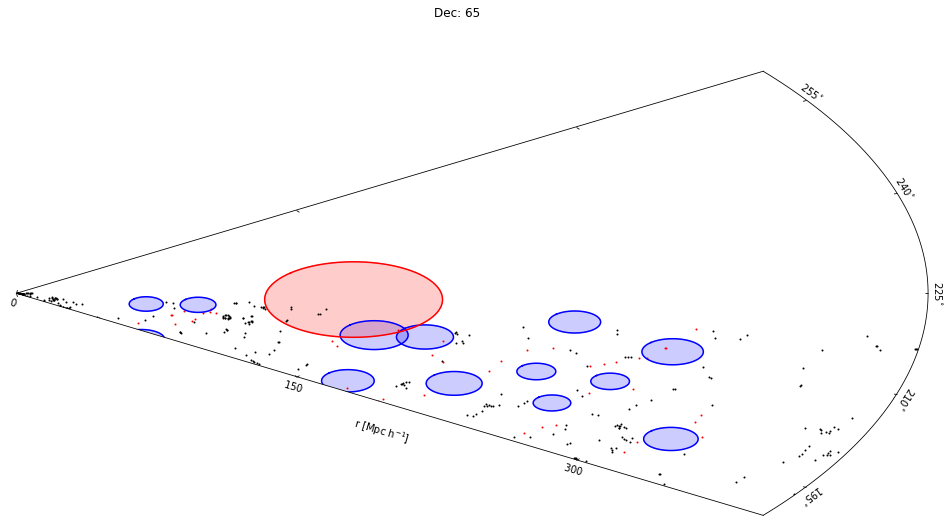

In [30]:
# maximals = pvf(,1,1000)

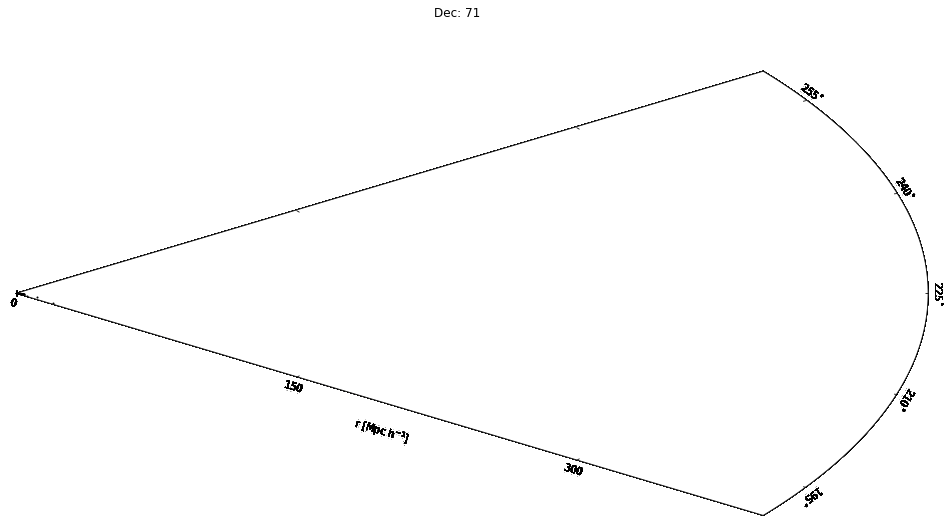

In [31]:
#generating slice images
for i in np.arange(0,51,1):
    maximals = pvf((21 + i),1,1000)
    maximals.savefig((str(i)+'m.jpg'),dpi=60)

In [13]:
# for i in np.arange(0,16.5,0.5):
#     holes = pvf2((38 + i),1,1000,6)
#     holes.savefig((str(i)+'holes2.jpg'),dpi=120)

In [14]:
# for i in np.arange(0,16.5,0.5):
#     galaxies = gals((38 + i),1,1000)
#     galaxies.savefig((str(i)+'gals2.jpg'),dpi=120)